# Gradient free optimization study. Full-Low Evaluation Method

Zarezina Elizaveta

## Test functions

In [294]:
from IPython.display import clear_output

In [295]:
!git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective
clear_output()

In [296]:
import sys
sys.path.append('/content/Python_Benchmark_Test_Optimization_Function_Single_Objective')
import pybenchfunction as bench
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import scipy.optimize
warnings.filterwarnings('ignore')

Rastrigin function, global minimum: coordinates [0 0], value: 0.0


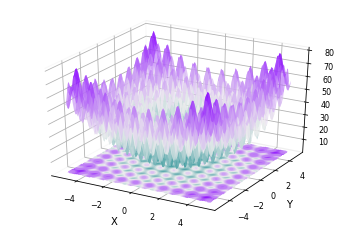

Ackley function, global minimum: coordinates [0 0], value: 4.440892098500626e-16


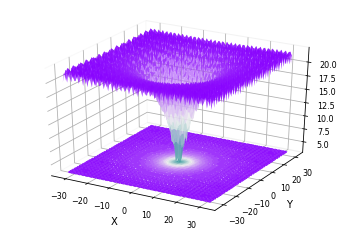

Rosenbrock function, global minimum: coordinates [1 1], value: 0


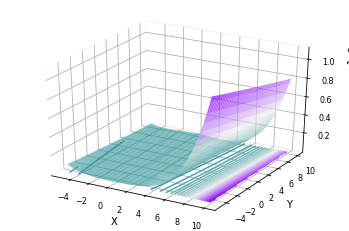

Bukin N. 6 function, global minimum: coordinates [-10   1], value: 0.0


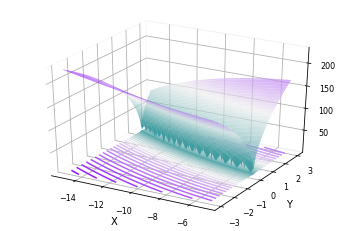

Easom function, global minimum: coordinates [3.14159265 3.14159265], value: -1.0


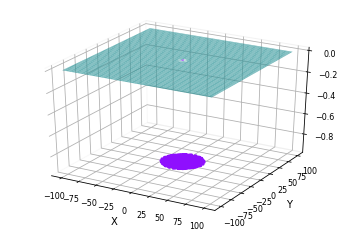

Schaffel N. 2 function, global minimum: coordinates [0 0], value: 0.0


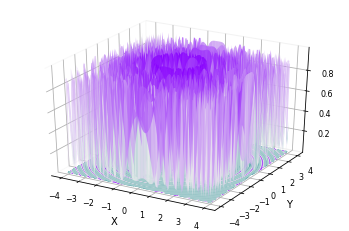

In [297]:
# Several test functions (test problems of this project), 2D

N = 2 # dimensions

functions = {bench.function.Rastrigin(N) : bench.function.Rastrigin(N).get_global_minimum(N), bench.function.Ackley(N) : bench.function.Ackley(N).get_global_minimum(N), 
             bench.function.Rosenbrock(N) : bench.function.Rosenbrock(N).get_global_minimum(N), bench.function.BukinN6(N) : bench.function.BukinN6(N).get_global_minimum(N),
             bench.function.Easom(N) : bench.function.Easom(N).get_global_minimum(N), bench.function.SchaffelN2(N) : bench.function.SchaffelN2(N).get_global_minimum(N)}

for function in functions.keys():
          print(f'{function.name} function, global minimum: coordinates {functions[function][0]}, value: {functions[function][1]}')
          bench.plot_3d(function, n_space = 100, ax = None)


# "Classical" methods of gradient free optimization

## Bayessian optimization

In [298]:
! pip install optuna
clear_output()

In [299]:
import optuna

## Simulated annealing

In [300]:
def simulated_annealing(func, initial_state, N_steps):
    alpha = 0.1
    initial_temp = 3 * N_steps * alpha
    
    current_temp = initial_temp

    # Start by initializing the current state with the initial state
    current_state = initial_state
    solution = current_state

    while current_temp > 0:
        neighbor = current_state + np.random.randn(np.shape(current_state)[0])

        # Check if neighbor is the best so far
        cost_diff = func(current_state) - func(neighbor)

        # if the new solution is better, accept it
        if cost_diff > 0 or np.random.uniform(0, 1) < np.exp(-cost_diff / current_temp):
              solution = neighbor
        # decrement the temperature
        current_temp -= alpha

    return solution, func(solution)


# Full-Low Evaluations Method

In [301]:
# Hyperparameters

theta = 0.2
lmbda = 2
gamma = 0.5
tau = 0.8
c = 0.1


In [302]:
def Full(x0, f, alpha, beta, Nfev, Nsteps, noise = False):
    N = np.shape(x0)[0]
    x = x0
    # Direction based on the approximate gradient (FD):
    Nfev += 2
    while Nfev < Nsteps:
          g = fd(f, x, noise)
          if (beta < gamma * alpha):
              return [Nfev] 
          while f(x - beta * g + noise * np.random.randn(N)) > f(x + noise * np.random.randn(N)) - c * beta * (g.T @ g):
              Nfev += 2
              beta = tau * beta
              if beta < gamma * alpha:
                    return [Nfev]
          if beta >= gamma * alpha:
              x = x - beta * g        
              return [Nfev, x]
    return [Nsteps, x]


In [303]:
def fd(f, x, noise = False):
    h = (sys.float_info.epsilon) ** 0.5
    N = np.shape(x)[0]
    g = np.zeros(N)
    for i in range(N):
        e = np.zeros(N)
        e[i] = 1
        g[i] = (f(x + h * e + noise * np.random.randn(N)) - f(x + noise * np.random.randn(N))) / h
    return g


In [304]:
def Low(x0, f, alpha, Nfev, noise = False):
    N = np.shape(x0)[0]
    x = x0
    # Generate a direction randomly
    d = np.random.randn(N) * 0.5
    if f(x + alpha * d + noise * np.random.randn(N)) <= f(x + noise * np.random.randn(N)) - alpha:
        Nfev += 2
        x = x + alpha * d
        alpha = lmbda * alpha
    elif f(x - alpha * d + noise * np.random.randn(N)) <= f(x + noise * np.random.randn(N)) - alpha:
        Nfev += 2
        x = x - alpha * d
        alpha = lmbda * alpha
    else:
        alpha = theta * alpha
    return x0, alpha, Nfev


In [305]:
def FullLow(f, x0, Nsteps, noise = False):
    Nfev = 0
    x = x0
    N = np.shape(x)[0]
    alpha = np.random.randn(1) * 0.5
    beta = np.random.randn(1) * 0.5
    result_full = Full(x, f, alpha, beta, Nfev, Nsteps, noise)
    Nfev = result_full[0]
    if len(result_full) == 2:
        x = result_full[1]
    elif Nfev + 2 < Nsteps:
        x, alpha, Nfev = Low(x, f, alpha, Nfev, noise)
    return x


# Numerical experiments

In [306]:
x0 = np.random.randn(N) * 10
Nsteps = 1e5
Ntrials = 50


In [307]:
functions_opt = dict()
for function in functions.keys():
      functions_opt[function] = dict()
      

In [308]:
for function in functions.keys():

      # For Bayessian Optimization (optuna)

      def objective(trial):
          x = np.zeros(N)
          for i in range(N):
                x[i] = trial.suggest_float(str(i), -10, 10)
          return function(x)

      study = optuna.create_study()
      study.optimize(objective, n_trials=Ntrials)
      functions_opt[function]['Bayess'] = (study.best_params, study.best_value, Ntrials)

      functions_opt[function]['BFGS'] = scipy.optimize.fmin_bfgs(function, x0, maxiter = 2 * Nsteps)
      functions_opt[function]['Powell'] = scipy.optimize.minimize(function, x0, method='Powell', options = {'maxfev' : 6 * Nsteps})
      functions_opt[function]['N-M'] = scipy.optimize.minimize(function, x0, method='Nelder-Mead', options = {'maxfev' : 6 * Nsteps})
      functions_opt[function]['SimAnn'] = simulated_annealing(function, x0, Nsteps)
      functions_opt[function]['FL'] = FullLow(function, x0, 6 * Nsteps)
                 
clear_output()


In [309]:
effectiveness = dict()
for function in functions.keys():
      effectiveness[function] = dict()
      

In [310]:
for function in functions.keys():
      effectiveness[function]['BFGS'] = np.linalg.norm(functions_opt[function]['BFGS'] - functions[function][0])
      effectiveness[function]['Powell'] = np.linalg.norm(functions_opt[function]['Powell'].x - functions[function][0])
      effectiveness[function]['N-M'] = np.linalg.norm(functions_opt[function]['N-M'].x - functions[function][0])
      effectiveness[function]['SimAnn'] = np.linalg.norm(functions_opt[function]['SimAnn'][0][0] - functions[function][0])
      effectiveness[function]['Bayess'] = np.linalg.norm(np.array((functions_opt[function]['Bayess'][0]['0'], functions_opt[function]['Bayess'][0]['1'])) - functions[function][0])
      effectiveness[function]['FL'] = np.linalg.norm(functions_opt[function]['FL'] - functions[function][0])


[]

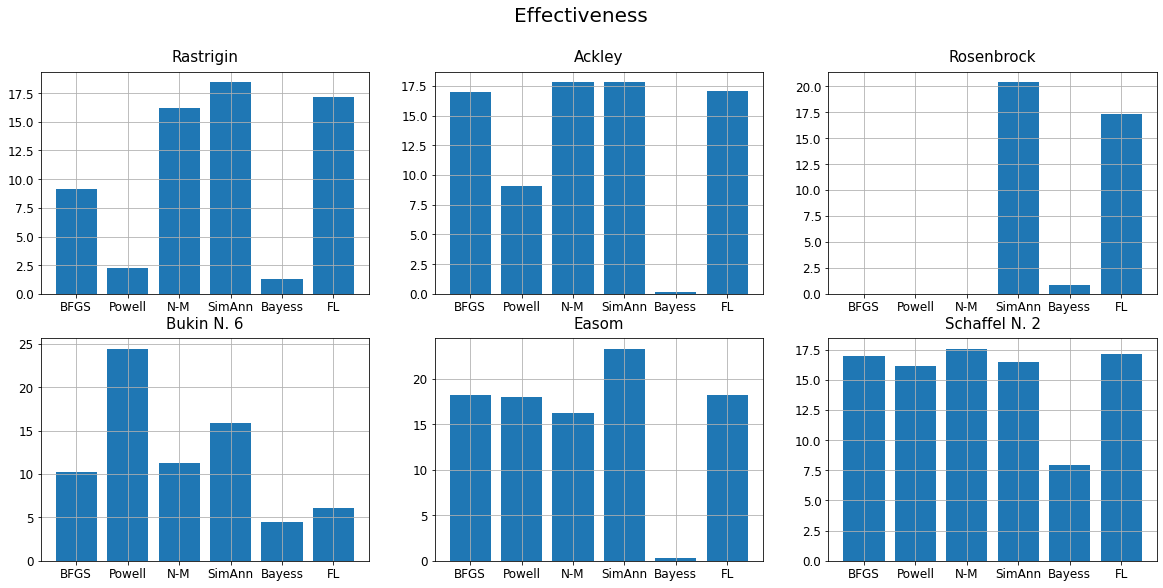

In [311]:
fig, axs = plt.subplots(2, 3, figsize=(20, 9))
fig.suptitle('Effectiveness', fontsize = 20)
idx = 0
for function in functions.keys():
      axs[idx // 3, idx % 3].grid()
      axs[idx // 3, idx % 3].set_title(function.name, fontsize = 15, pad = 10)
      axs[idx // 3, idx % 3].bar(effectiveness[function].keys(), effectiveness[function].values())
      axs[idx // 3, idx % 3].tick_params(axis='both', which='major', labelsize=12)
      idx += 1
plt.plot()


In [312]:
value = dict()
for function in functions.keys():
      value[function] = dict()
      

In [313]:
for function in functions.keys():
      value[function]['BFGS'] = function(functions_opt[function]['BFGS'])
      value[function]['Powell'] = function(functions_opt[function]['Powell'].x)
      value[function]['N-M'] = function(functions_opt[function]['N-M'].x)
      value[function]['SimAnn'] = functions_opt[function]['SimAnn'][0][1]
      value[function]['Bayess'] = function(np.array((functions_opt[function]['Bayess'][0]['0'], functions_opt[function]['Bayess'][0]['1'])))
      value[function]['FL'] = function(functions_opt[function]['FL'])


[]

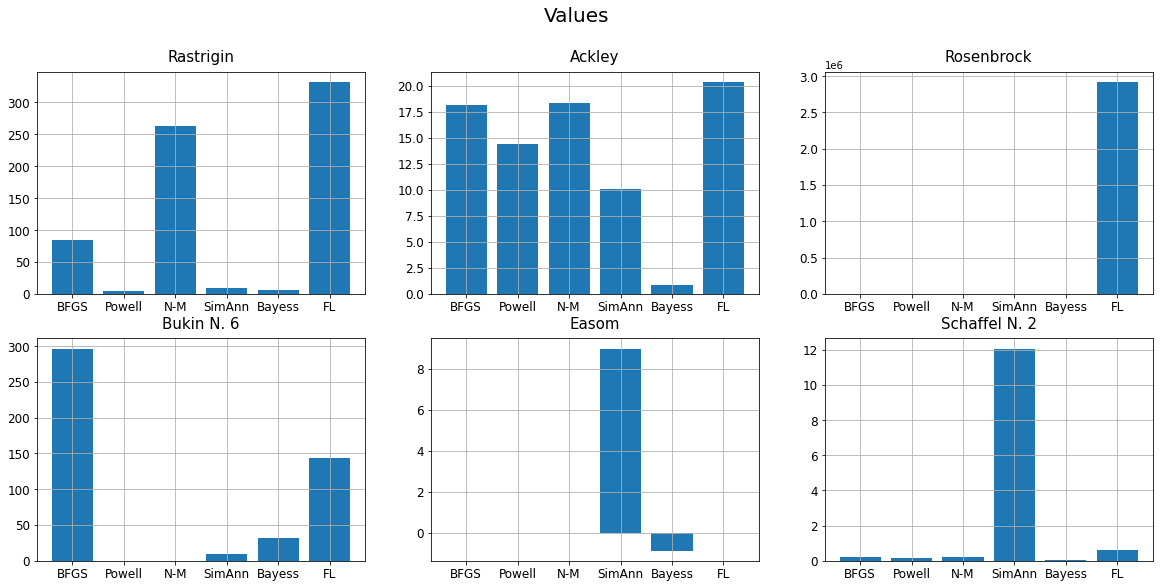

In [314]:
# Functions' optimum values obtained via these methods
fig, axs = plt.subplots(2, 3, figsize=(20, 9))
fig.suptitle('Values', fontsize = 20)
idx = 0
for function in functions.keys():
      axs[idx // 3, idx % 3].grid()
      axs[idx // 3, idx % 3].set_title(function.name, fontsize = 15, pad = 10)
      axs[idx // 3, idx % 3].bar(value[function].keys(), value[function].values())
      axs[idx // 3, idx % 3].tick_params(axis='both', which='major', labelsize=12)
      idx += 1
plt.plot()


# Noisy cases

In [315]:
noisy_functions = {bench.function.Rastrigin(N) : bench.function.Rastrigin(N).get_global_minimum(N), bench.function.Ackley(N) : bench.function.Ackley(N).get_global_minimum(N), 
             bench.function.Rosenbrock(N) : bench.function.Rosenbrock(N).get_global_minimum(N),  
             bench.function.BukinN6(N) : bench.function.BukinN6(N).get_global_minimum(N), bench.function.Easom(N) : bench.function.Easom(N).get_global_minimum(N), 
             bench.function.SchaffelN2(N) : bench.function.SchaffelN2(N).get_global_minimum(N)}


In [316]:
noisy_duration = dict()
noisy_functions_opt = dict()
for function in noisy_functions.keys():
      noisy_duration[function] = list()
      noisy_functions_opt[function] = list()


In [317]:
for function in noisy_functions.keys():
      start = time.time()
      noisy_functions_opt[function] = FullLow(function, x0, Nsteps, noise = True)
      noisy_duration[function] = time.time() - start              
clear_output()


In [318]:
noisy_effectiveness = dict()
for function in noisy_functions.keys():
      noisy_effectiveness[function] = list()
      

In [319]:
for function in noisy_functions.keys():
      noisy_effectiveness[function] = np.linalg.norm(noisy_functions_opt[function] - noisy_functions[function][0])


[]

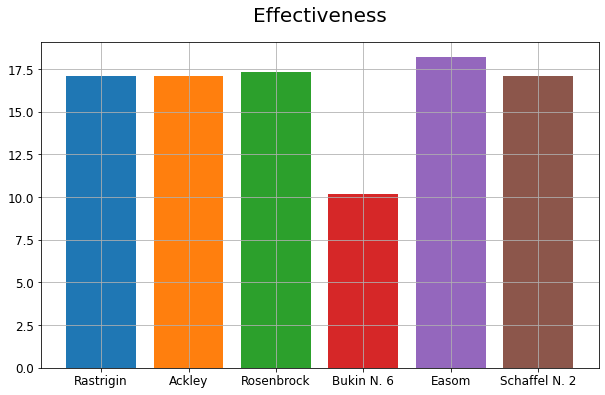

In [320]:
plt.figure(figsize=(10, 6))
plt.title('Effectiveness', fontsize = 20, pad=20)
plt.grid()
for function in noisy_functions.keys():
      plt.bar(function.name, noisy_effectiveness[function])
      plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot()


[]

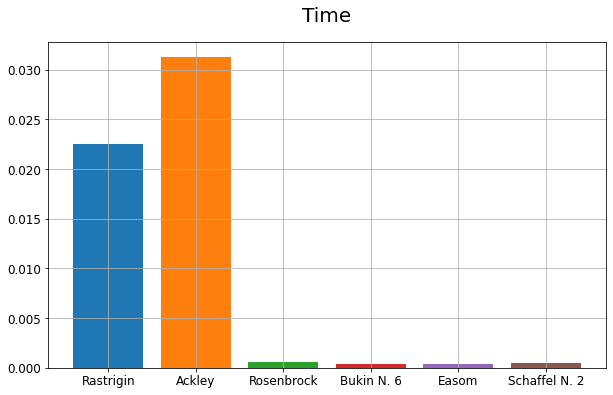

In [321]:
plt.figure(figsize=(10, 6))
plt.title('Time', fontsize = 20, pad = 20)
plt.grid()
for function in noisy_functions.keys():
      plt.bar(function.name, noisy_duration[function])
      plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot()


In [322]:
noisy_value = dict()
for function in noisy_functions.keys():
      noisy_value[function] = list()
      

In [323]:
for function in noisy_functions.keys():
      noisy_value[function] = function(noisy_functions_opt[function])


[]

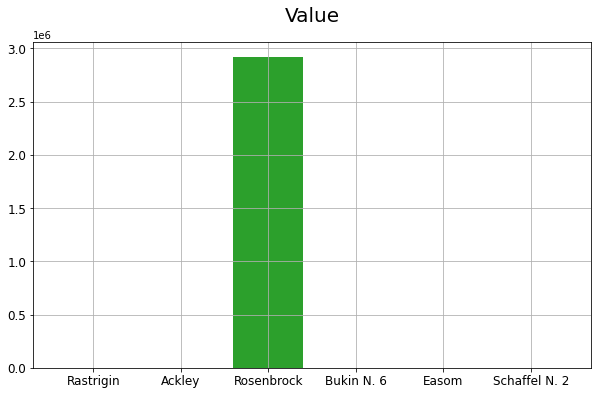

In [324]:
plt.figure(figsize=(10, 6))
plt.title('Value', fontsize = 20, pad = 20)
plt.grid()
for function in noisy_functions.keys():
      plt.bar(function.name, noisy_value[function])
      plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot()
